In [100]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

# Define constants
k = 8.987155e9  # N * m^2 * C^-2 (Coulomb constant)
dt = 0.1 * 1e-15  # Time step (in seconds). dt = 0.1*10e-15 s = 0.1 fs
num_steps = 100000  # Number of steps



# Initial conditions for three bodies (mass , charge , position, velocity)
# initial mass
m1 = 32.0 * 1.67377e-27 # Mass of atom 1 (in kg) 1 atom weight = 1.67377 * 10^-27 kg
m2 = 16.0 * 1.67377e-27 # Mass of atom 2 (in kg) 1 atom weight = 1.67377 * 10^-27 kg
m3 = 16.0 * 1.67377e-27 # Mass of atom 3 (in kg) 1 atom weight = 1.67377 * 10^-27 kg


k_l = 1.45
# Initial positions (in meters)
r1 = np.array([0.0, 0.370873]) * 1e-10 *k_l
r2 = np.array([1.261748, -0.370873]) * 1e-10*k_l
r3 = np.array([-1.261748, -0.370873]) * 1e-10*k_l

# Initial velocities (in meters/second)
v1 = np.array([0.0, 0.0])
v2 = np.array([0.0, 0.0])
v3 = np.array([0.0, 0.0])

# each atom's final charge
Q1_f = 1 * 1.602e-19 # charge of atom 1 (in Elementary charge) 1 elementary charge = 1.602 * 10^-19 coulombs
Q2_f = 1 * 1.602e-19 # charge of atom 2  (in Elementary charge) 1 elementary charge = 1.602 * 10^-19 coulombs
Q3_f = 1 * 1.602e-19 # charge of atom 3  (in Elementary charge) 1 elementary charge = 1.602 * 10^-19 coulombs

#Each atom's initial charge
Q2_ini = 0.77* 1.602e-19 # charge of atom 2  (in Elementary charge) 1 elementary charge = 1.602 * 10^-19 coulombs
Q3_ini = 0.77 * 1.602e-19 # charge of atom 3  (in Elementary charge) 1 elementary charge = 1.602 * 10^-19 coulombs
Q1_ini = Q1_f + Q2_f + Q3_f - Q2_ini - Q3_ini


Re = 1.46*1e-10 #unit is m. This is the equilibrium S-O bond length in SO2 molecule.
Rc = 3.0*1e-10 #This is a constant that describes the critical distance beyond which the charge states converge

time_depend_charge = False #Detetmine whether the charge on each atom is a constant or a changed value

In [101]:
# Functions

def charge_over_time(ini_charge, final_charge, bond_length):
    """
    Calculate the charge over time.

    Parameters:
    ini_charge (float): Initial charge
    final_charge (float): Final charge
    bond_length (float): Bond length

    Returns:
    float: Calculated charge over time
    """
    if time_depend_charge:
        Q_t = final_charge * (1 - (1 - ini_charge / final_charge) * math.exp((Re - bond_length) / Rc))
    else:
        Q_t = final_charge
                              
    return Q_t


def calculate_acceleration(r1, r2, r3, Q1_t, Q2_t, Q3_t):
    a1 = k / m1 * (Q1_t * Q2_t * (r1 - r2)/ np.linalg.norm(r1 - r2)** 3 + Q1_t * Q3_t * (r1 - r3) / np.linalg.norm(r1 - r3) ** 3)
    a2 = k / m2 * (Q2_t * Q1_t * (r2 - r1)/ np.linalg.norm(r2 - r1)** 3 + Q2_t * Q3_t * (r2 - r3) / np.linalg.norm(r2 - r3) ** 3)
    a3 = k / m3 * (Q1_t * Q3_t * (r3 - r1)/ np.linalg.norm(r3 - r1)** 3 + Q2_t * Q3_t * (r3 - r2) / np.linalg.norm(r3 - r2) ** 3)
    return a1, a2, a3

def calculate_first_step_r(r1, r2, r3, a1, a2, a3):
    r1_2 = r1 + v1*dt + 0.5 * a1 * dt**2
    r2_2 = r2 + v2*dt + 0.5 * a2 * dt**2
    r3_2 = r3 + v3*dt + 0.5 * a3 * dt**2
    return r1_2, r2_2, r3_2

In [102]:
# Calculate initial accelerations
a1, a2, a3 = calculate_acceleration(r1, r2, r3, Q1_ini, Q2_ini, Q3_ini)

#Calculate initial positions
r1_2, r2_2, r3_2 = calculate_first_step_r(r1, r2, r3, a1, a2, a3)

# Arrays to store positions for plotting
positions = np.zeros((num_steps, 3, 2))
velocities = np.zeros((num_steps, 3, 2))

positions[0] = [r1, r2, r3]
positions[1] = [r1_2, r2_2, r3_2]
velocities[0] = [v1, v2, v3]

#Do the initial positions settins in the loop
r1_old, r2_old, r3_old = r1, r2, r3
r1_now, r2_now, r3_now = r1_2, r2_2, r3_2


# Verlet integration loop
for step in range(2, num_steps):
    
    #Update charges
    Q2_now = charge_over_time(Q2_ini, Q2_f, np.linalg.norm(r2_now - r1_now))
    Q3_now = charge_over_time(Q3_ini, Q3_f, np.linalg.norm(r3_now - r1_now))
    Q1_now = Q1_f + Q2_f + Q3_f - Q2_now - Q3_now
    

    # Calculate new accelerations with updated positions
    a1_now, a2_now, a3_now = calculate_acceleration(r1_now, r2_now, r3_now, Q1_now, Q2_now, Q3_now)


    
    #Update the new position
    r1_new = 2 * r1_now - r1_old + a1_now * dt**2
    r2_new = 2 * r2_now - r2_old + a2_now * dt**2
    r3_new = 2 * r3_now - r3_old + a3_now * dt**2
    
    # Update velocities using the average of the current and new accelerations
    v1 = 0.5 * (r1_new - r1_old)/dt
    v2 = 0.5 * (r2_new - r2_old)/dt
    v3 = 0.5 * (r3_new - r3_old)/dt




    # Store positions for plotting
    positions[step] = [r1_new, r2_new, r3_new]
    velocities[step-1] = [v1, v2, v3]
    
    # Update positions and accelerations for the next step
    r1_old, r2_old, r3_old = r1_now, r2_now, r3_now
    r1_now, r2_now, r3_now = r1_new, r2_new, r3_new


S kenetic energy is 2.6642588411052834 eV
O1 kenetic energy is 7.402329756122897 eV
O2 kenetic energy is 7.402329756122897 eV
total KER is 17.468918353351075 eV
S momentum is 2.1382781708407765e-22 kgm/s
O1 momentum is 2.520259211266473e-22 kgm/s
O2 momentum is 2.520259211266473e-22 kgm/s
S momentum is 107.2974970941504 a.u.
O1 momentum is 126.46507320001369 a.u.
O2 momentum is 126.46507320001369 a.u.
[   0.         3992.25657281]
[ 8522.10237059 -3992.25657281]
[-8522.10237059 -3992.25657281]
OSO bond angle is 129.7976610877176 degree


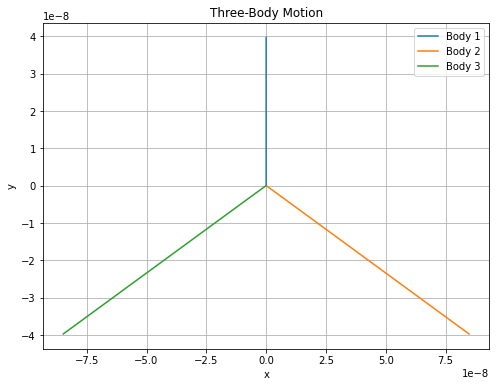

In [103]:
import math

#calculate and print the KE of each ion
KE1 = 0.5 * m1 * np.linalg.norm(v1)**2 * 6.242e18 #calculate the final kenetic energy of each ion. Unit is eV
KE2 = 0.5 * m2 * np.linalg.norm(v2)**2 * 6.242e18
KE3 = 0.5 * m3 * np.linalg.norm(v3)**2 * 6.242e18
print('S kenetic energy is' + ' '+ str(KE1) + ' eV')
print('O1 kenetic energy is' + ' '+ str(KE2) + ' eV')
print('O2 kenetic energy is' + ' '+ str(KE3) + ' eV')
print('total KER is ' + str(KE1+KE2+KE3) + ' eV')



#Calculate the momentum of each ion, unit is kgm/s
P1 = m1 * np.linalg.norm(v1)
P2 = m2 * np.linalg.norm(v2)
P3 = m3 * np.linalg.norm(v3)
print('S momentum is' + ' '+ str(P1) + ' kgm/s')
print('O1 momentum is' + ' '+ str(P2) + ' kgm/s')
print('O2 momentum is' + ' '+ str(P3) + ' kgm/s')

#calculate the momentun of each in a.u.
P1_au = P1/(1.99285e-24)
P2_au = P2/(1.99285e-24)
P3_au = P3/(1.99285e-24)
print('S momentum is' + ' '+ str(P1_au) + ' a.u.')
print('O1 momentum is' + ' '+ str(P2_au) + ' a.u.')
print('O2 momentum is' + ' '+ str(P3_au) + ' a.u.')

#Output each fragment's final angle between movement direction and x axis


print(v1)

print(v2)
print(v3)

angle = 360*(math.atan(v3[0]/v3[1]))/math.pi
print('OSO bond angle is'+ ' ' +str(angle)+' '+'degree')

# Plot the trajectories
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(positions[:, i, 0], positions[:, i, 1], label=f"Body {i+1}")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Three-Body Motion")
plt.legend()
plt.grid(True)